# Resources:
- https://arxiv.org/pdf/2105.08655.pdf
- https://sahilkhose.medium.com/paper-presentation-e9bd0f3fb0bf
- https://towardsdatascience.com/binary-image-classification-in-pytorch-5adf64f8c781
- https://www.mdpi.com/2073-4441/15/5/875

# Paths

In [1]:
resnet_path = '/content/drive/My Drive/SAT/project/80-20/final_best_resnet.pt'
efficientnet_path = '/content/drive/My Drive/SAT/project/80-20/final_best_efficientnet.pt'
mobilenet_path = '/content/drive/My Drive/SAT/project/80-20/final_best_mobilenet.pt'
testset_path = '/content/drive/My Drive/SAT/project/test'
output_path = '/content/drive/My Drive/SAT/project/output.txt'

# Imports

In [2]:
! pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import zipfile
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torch.utils.data import TensorDataset, DataLoader,Dataset
from torchvision import datasets, transforms,models
import torch.nn as nn
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import lr_scheduler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import calinski_harabasz_score
from torchvision.datasets import ImageFolder
import albumentations
from sklearn.metrics import f1_score
from keras.preprocessing.image import ImageDataGenerator
import timm

In [4]:
# Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive')

# # change directory to the folder where the data is stored
# %cd /content/drive/My Drive/SAT/project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Helpers

In [5]:
def extract_file(zip_path,specified_directory):
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(specified_directory)

In [6]:
def read_images(flooded_path, non_flooded_path, width, height):
    flooded = np.empty((0, width, height, 3))
    non_flooded = np.empty((0, width, height, 3))

    for filename in os.listdir(flooded_path):
        img = cv2.imread(os.path.join(flooded_path, filename), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (width, height)) 
        img = img.astype('float32') / 255.0 
        img = np.expand_dims(img, axis=0)
        flooded = np.concatenate((flooded, img), axis=0)

    for filename in os.listdir(non_flooded_path):
        img = cv2.imread(os.path.join(non_flooded_path, filename), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (width, height)) 
        img = img.astype('float32') / 255.0  
        img = np.expand_dims(img, axis=0) 
        non_flooded = np.concatenate((non_flooded, img), axis=0)
    return flooded,non_flooded

In [7]:
def show_img(img,title=""):
   plt.imshow(img)
   plt.title(title)
   plt.show()

In [8]:
def show_images(images,images_labels):
  nrows = 4
  ncols = 4
  fig, ax = plt.subplots(nrows,ncols,figsize = (10,10))
  ax = ax.flatten()
  for i in range(nrows*ncols):
      pic = images[i%len(images)]
      ax[i].imshow(pic)
      ax[i].set_title(images_labels[i%len(images)])
      ax[i].set_axis_off()
  plt.show()

In [9]:
def calc_metrics(y, y_pred, model_name):
    cm = confusion_matrix(y, y_pred)
    cr = classification_report(y, y_pred)
    fn = cm[1][0]
    pos = cm[1][0] + cm[1][1]
    omission_error = fn / pos
    fp = cm[0][1]
    neg = cm[0][0] + cm[0][1]
    commission_error = fp / neg
    print(f"Model: {model_name}")
    print(cm)
    print(cr)
    print("Omission error rate:", omission_error)
    print("Commission error rate:", commission_error)

# Constants

In [10]:
CFG = {
    'img_size': 256, # width and height of the image
    'epochs': 10, # number of epochs
    'train_bs': 16, # batch size for training
    'val_bs': 32, # batch size for validation
    'test_bs': 32, # batch size for testing
    'lr': 1e-5, # learning rate
    'freeze': False, # if you want to freeze pretrain model weights
    'out_features': 1, # number of output features (1 for binary classification)
    'dataset_path': '/content/drive/My Drive/SAT/project/dataset/dataset', # path to the root dataset folder
    'flooded_path': '/content/drive/My Drive/SAT/project/dataset/dataset/flooded', # path to the flooded images
    'non_flooded_path': '/content/drive/My Drive/SAT/project/dataset/dataset/non-flooded', # path to the non flooded images
    'val_ratio': 0.2, # ratio for validation set
    'early_stopping_tolerance': 5,  # early stopping patience (using grid search)
    'early_stopping_threshold': 0.03 # early stopping threshold (using grid search)
    }

# Augmentation

In [11]:
val_aug = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            )
        ])

test_aug = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            )
        ])

# Models


In [12]:
class Resnet(nn.Module):
    def __init__(self, pretrained=True, freeze=CFG['freeze'], out_features=CFG['out_features']):
        super(Resnet, self).__init__()

        self.model = timm.create_model('resnet14t', pretrained=pretrained)

        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False

        self.model.fc = nn.Linear(self.model.fc.in_features, out_features)

    def forward(self, x):
        return self.model(x)

In [13]:
class Efficientnet(nn.Module):
    def __init__(self, pretrained=True, freeze=CFG['freeze'], out_features=CFG['out_features']):
        super(Efficientnet, self).__init__()

        self.model = timm.create_model('efficientnet_b0', pretrained=pretrained)

        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False

        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, out_features)

    def forward(self, x):
        return self.model(x)

In [14]:
class Mobilenet(nn.Module):
    def __init__(self, pretrained=True, freeze=CFG['freeze'], out_features=CFG['out_features']):
        super(Mobilenet, self).__init__()

        self.model = timm.create_model('mobilenetv3_large_100', pretrained=pretrained)

        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False

        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, out_features)

    def forward(self, x):
        return self.model(x)

# Ensemble the models

In [15]:
# Ensemble model
class Ensemble(nn.Module):
    def __init__(self, models):
        super(Ensemble, self).__init__()
        self.models = models

    def forward(self, x):
        predictions = []
        for model in self.models:
            predictions.append(model(x))
        # Aggregate predictions (e.g., averaging)
        output = torch.mean(torch.stack(predictions), dim=0)
        return output

# Evaluate the models

In [16]:
def evaluate(model, val_loader, criterion, device):
    model.eval()
    y_true = []
    y_pred = []
    running_loss = 0.0
    with torch.no_grad():
      for batch_idx, (input, target) in enumerate(tqdm(val_loader)):
            input = input.permute(0, 3, 1, 2)
            input = input.to(device)
            target = target.unsqueeze(1).float()
            target = target.to(device)

            scores = model(input)
            loss = criterion(scores, target)

            running_loss += loss.item()

            predicted = torch.round(torch.sigmoid(scores))
            y_true.extend(target.flatten().tolist())
            y_pred.extend(predicted.flatten().tolist())

    calc_metrics(y_true, y_pred, "")

    return running_loss/len(val_loader), f1_score(y_true, y_pred, average='macro')

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load best models

In [18]:
model1 = Resnet().to(device)
model1.load_state_dict(torch.load(resnet_path))

# criterion = nn.BCEWithLogitsLoss()
# val_loss, val_f1 = evaluate(model1, val_loader, criterion, device)
# print(f"Validation loss: {val_loss} Validation macro f1: {100*val_f1:.2f}%")

<All keys matched successfully>

In [19]:
model2 = Efficientnet().to(device)
model2.load_state_dict(torch.load(efficientnet_path))

# criterion = nn.BCEWithLogitsLoss()
# val_loss, val_f1 = evaluate(model2, val_loader, criterion, device)
# print(f"Validation loss: {val_loss} Validation macro f1: {100*val_f1:.2f}%")

<All keys matched successfully>

In [20]:
model3 = Mobilenet().to(device)
model3.load_state_dict(torch.load(mobilenet_path))

# criterion = nn.BCEWithLogitsLoss()
# val_loss, val_f1 = evaluate(model3, val_loader, criterion, device)
# print(f"Validation loss: {val_loss} Validation macro f1: {100*val_f1:.2f}%")

<All keys matched successfully>

In [21]:
ensemble = Ensemble([model1, model2, model3])

# criterion = nn.BCEWithLogitsLoss()
# val_loss, val_f1 = evaluate(ensemble, val_loader, criterion, device)
# print(f"Validation loss: {val_loss} Validation macro f1: {100*val_f1:.2f}%")

# Inference

In [22]:
def predict(model, test_loader, device):
    model.eval()
    y_pred = []
    with torch.no_grad():
      for batch_idx, (input, _) in enumerate(tqdm(test_loader)):
            input = input.permute(0, 3, 1, 2)
            input = input.to(device)

            scores = model(input)

            predicted = torch.round(torch.sigmoid(scores))
            y_pred.extend(predicted.flatten().tolist())
    return y_pred

In [23]:
def read_testset(testset_path, width, height):
    testset = np.empty((0, width, height, 3))

    for filename in sorted(os.listdir(testset_path)):
        img = cv2.imread(os.path.join(testset_path, filename), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (width, height)) 
        img = img.astype('float32') / 255.0 
        img = np.expand_dims(img, axis=0)
        testset = np.concatenate((testset, img), axis=0)
    
    return testset

In [24]:
X_test = read_testset(testset_path, CFG['img_size'], CFG['img_size'])

X_test_tensor = torch.from_numpy(X_test).float()
dummy = torch.zeros(X_test_tensor.size(0))

test_dataset = TensorDataset(X_test_tensor, dummy)
test_dataset.transforms = test_aug

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=CFG['test_bs'])

In [25]:
y_pred = predict(ensemble, test_loader, device)

100%|██████████| 1/1 [00:03<00:00,  3.03s/it]


In [26]:
y_pred = [str(int(element)) for element in y_pred]
# Open the file in write mode
with open(output_path, 'w') as file:
    # Join the elements of the list with white space separator and write to the file
    file.write('\n'.join(y_pred))

In [27]:
# Open the text file in read mode
with open(output_path, 'r') as file:
    # Read the lines of the file into an array
    y_pred = file.readlines()
# Create a list from the lines
y_pred = [int(line) for line in y_pred]

In [28]:
print(y_pred)

[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]


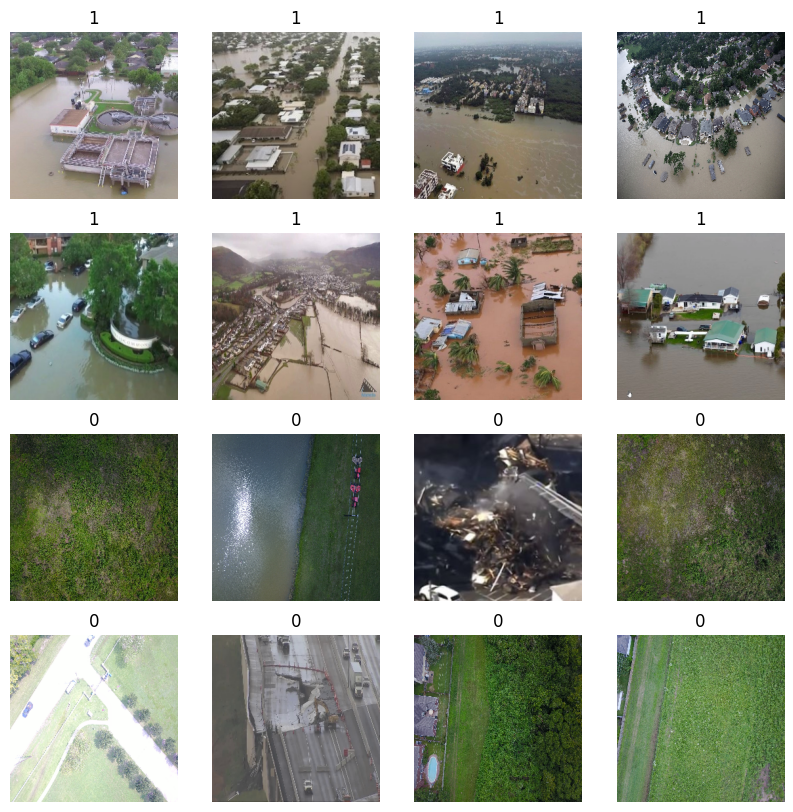

In [29]:
show_images(X_test, y_pred)